In [1]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import open3d as o3d

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
events_raw = np.loadtxt(path + "data/slider-depth/events.txt")

In [3]:
events_ref = flt.filter_refract(events_raw, 0.1)

In [19]:
start_time = 2.5
duration = 0.1
events_t = flt.filter_time(events_ref, start_time, start_time+duration)

In [26]:
img_grey = plt.imread(path + "data/slider-depth/images/frame_00000066.png")

In [20]:
patch_center = (90, 90)
patch_size = 180
shape = (patch_size, patch_size)
events = flt.filter_patch(events_t, patch_center, patch_size)

shape = (patch_size, patch_size)

events = events_t
shape = (patch_size, patch_size)
shape = (180, 240)
events.shape

(22718, 4)

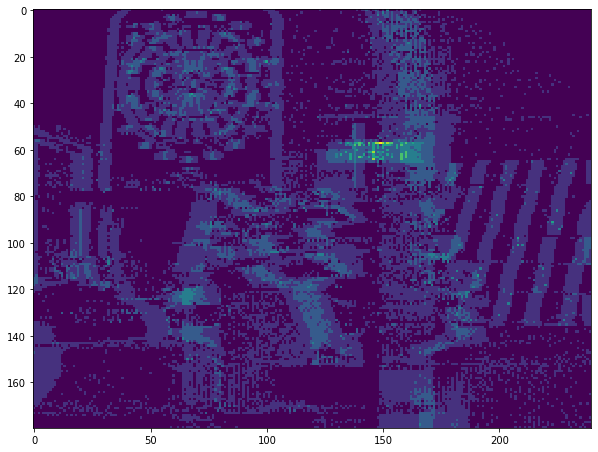

In [21]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(vis.events2img(events, shape, filter_polarity=False), interpolation="none")

In [37]:
pred_times ={}
last_time = np.zeros(shape)
time_difference = np.zeros(shape)
dist = 1
px_range = 5
y_shift = 1
final_td = np.zeros(shape)
mean = np.zeros(shape)
stds = []
for e in events:
#     if e[3] == 1:
#         continue
    x = int(e[1])
    y = int(e[2])
    t = e[0]
    k = (y, x)
    checked = False
    #decide if the event is accepted
    if k in pred_times and len(pred_times[k]) >= 5:
        times = np.array(pred_times[k])
        t_mean = np.mean(times)
        mean[y, x] = t_mean
        t_std = np.std(times)/2
        stds.append(t_std)
        
        #print(np.abs(t - t_mean))
        if t_std < 0.05:
            checked = True
            if np.abs(t - t_mean) > t_std:
                continue
    
    #measure time difference
    last_time[y, x] = e[0]
    if x >= shape[1] - dist or last_time[y, x + dist] == 0:
        continue
    
    t_dif = e[0] - last_time[y, x + dist]
    time_difference[y, x] = t_dif
    if checked:
        final_td[y, x] = t_dif
        pred_times[k] = []
    
    #make predictions
    for i in range(1, px_range+1):
        if x - i < 0:
            continue
        for h in range(y-y_shift, y+y_shift+1):
            if h < 0 or h >= shape[0]:
                continue
            
            ki = (h, x-i)
            pred = t + t_dif * i
            if ki in pred_times:
                pred_times[ki].append(pred)
            else:
                pred_times[ki] = [pred]      

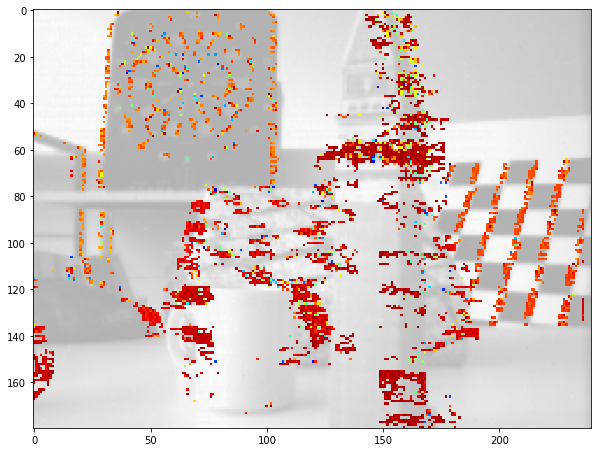

In [38]:
%matplotlib inline
plt.figure(figsize=(10, 10))
final_td_m = np.ma.masked_where(final_td == 0, final_td)
plt.imshow(img_grey, cmap="gray", alpha=0.3)
plt.imshow(final_td_m, cmap="jet_r", interpolation="none")

In [39]:
u = np.divide(1, final_td_m, where=final_td_m!=0)
d = td.td2depth_slider(u)
d = np.ma.masked_where(d==0, d)
%matplotlib qt
vis.visualize3d(d, s=2, range=(0.0, 3.0))
# %matplotlib inline
# plt.figure(figsize=(10, 10))
# plt.imshow(d, interpolation="none")

C:\Users\schiavaz\AppData\Local\Temp/ipykernel_2948/2119731341.py:1: RuntimeWarning: divide by zero encountered in true_divide
  u = np.divide(1, final_td_m, where=final_td_m!=0)


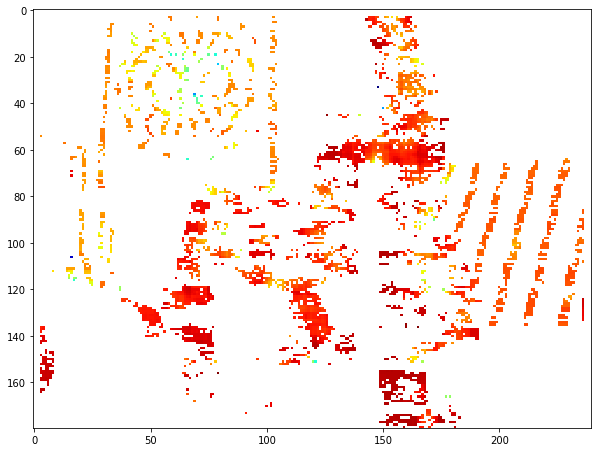

In [40]:
mean_filt = flt.mean_filter(d, 3)
%matplotlib inline
mean_filt_m = np.ma.masked_where(mean_filt == 0, mean_filt)
plt.figure(figsize=(10, 10))
plt.imshow(mean_filt_m, interpolation="none", cmap="jet_r")

In [41]:
%matplotlib qt
vis.visualize3d(mean_filt_m, s=2, range=(0.0, 3.0))

In [35]:
plt.figure(figsize=(10, 10))
time_difference_m = np.ma.masked_where(time_difference == 0, time_difference)
plt.imshow(time_difference_m, cmap="jet_r", interpolation="none")

In [171]:
test = np.zeros(shape)
for k in pred_times.keys():
    test[k[0], k[1]] = len(pred_times[k])

In [172]:
plt.figure(figsize=(10, 10))
m =plt.imshow(test, interpolation="none")
plt.colorbar(mappable=m)

In [173]:
test_m = np.ma.masked_where(test < 20, test)
plt.imshow(test_m)
np.nonzero(np.logical_not(test_m.mask))

(array([], dtype=int64), array([], dtype=int64))

In [174]:
#plt.hist(pred_times[21, 113], 10);
for l in pred_times[21, 113]:
    plt.axvline(x=l)
plt.axvline(x=np.mean(pred_times[21, 113]), color="red")
plt.axvline(x=np.mean(pred_times[21, 113]) + np.std(pred_times[21, 113]), color="yellow")
plt.axvline(x=np.mean(pred_times[21, 113]) - np.std(pred_times[21, 113]), color="yellow")

KeyError: (21, 113)

In [ ]:
plt.figure(figsize=(10, 10))
mean_m = np.ma.masked_where(mean == 0, mean)
plt.imshow(mean_m, cmap="jet_r", interpolation="none")